# Versión con Ajuste Fino (Fine-Tuning) para el modelo multi-salida

Esta versión del código implementa el ajuste fino descongelando las últimas capas del modelo base EfficientNetB0 para mejorar la adaptación a tu conjunto de datos.

In [2]:
# Importar librerías necesarias
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [3]:
# =============================================
# CONFIGURACIÓN
# =============================================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 30  # Entrenamiento inicial con base congelada
EPOCHS_FINE_TUNE = 30  # Entrenamiento con ajuste fino
LEARNING_RATE_INITIAL = 1e-4
LEARNING_RATE_FINE_TUNE = 1e-5
BASE_MODEL = 'EfficientNetB0'

In [5]:
# =============================================
# DICCIONARIOS DE MAPEO
# =============================================
label_to_cls_piezas = {
    1: "Antiniebla delantero derecho",
    2: "Antiniebla delantero izquierdo",
    3: "Capó",
    4: "Cerradura capo",
    5: "Cerradura maletero",
    6: "Cerradura puerta",
    7: "Espejo lateral derecho",
    8: "Espejo lateral izquierdo",
    9: "Faros derecho",
    10: "Faros izquierdo",
    11: "Guardabarros delantero derecho",
    12: "Guardabarros delantero izquierdo",
    13: "Guardabarros trasero derecho",
    14: "Guardabarros trasero izquierdo",
    15: "Luz indicadora delantera derecha",
    16: "Luz indicadora delantera izquierda",
    17: "Luz indicadora trasera derecha",
    18: "Luz indicadora trasera izquierda",
    19: "Luz trasera derecho",
    20: "Luz trasera izquierdo",
    21: "Maletero",
    22: "Manija derecha",
    23: "Manija izquierda",
    24: "Marco de la ventana",
    25: "Marco de las puertas",
    26: "Moldura capó",
    27: "Moldura puerta delantera derecha",
    28: "Moldura puerta delantera izquierda",
    29: "Moldura puerta trasera derecha",
    30: "Moldura puerta trasera izquierda",
    31: "Parabrisas delantero",
    32: "Parabrisas trasero",
    33: "Parachoques delantero",
    34: "Parachoques trasero",
    35: "Puerta delantera derecha",
    36: "Puerta delantera izquierda",
    37: "Puerta trasera derecha",
    38: "Puerta trasera izquierda",
    39: "Rejilla, parrilla",
    40: "Rueda",
    41: "Tapa de combustible",
    42: "Tapa de rueda",
    43: "Techo",
    44: "Techo corredizo",
    45: "Ventana delantera derecha",
    46: "Ventana delantera izquierda",
    47: "Ventana trasera derecha",
    48: "Ventana trasera izquierda",
    49: "Ventanilla delantera derecha",
    50: "Ventanilla delantera izquierda",
    51: "Ventanilla trasera derecha",
    52: "Ventanilla trasera izquierda"
}

label_to_cls_danos = {
    1: "Abolladura",
    2: "Deformación",
    3: "Desprendimiento",
    4: "Fractura",
    5: "Rayón",
    6: "Rotura"
}

label_to_cls_sugerencias = {
    1: "Reparar",
    2: "Reemplazar"
}

In [7]:
# =============================================
# CARGA DE DATOS
# =============================================
def load_and_prepare_data(split_dir):
    """Carga imágenes y etiquetas para un conjunto (train/val/test)"""
    df = pd.read_csv(f'{split_dir}/{split_dir.split("/")[-1]}_set.csv', sep='|')
    
    # Convertir strings de listas a listas reales
    for col in ['dannos', 'partes', 'sugerencias']:
        df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    
    return df

# Cargar todos los conjuntos
train_df = load_and_prepare_data('data/fotos_siniestros/train')
val_df = load_and_prepare_data('data/fotos_siniestros/val')
test_df = load_and_prepare_data('data/fotos_siniestros/test')

In [8]:
# =============================================
# PREPARACIÓN DE ETIQUETAS
# =============================================
mlb_partes = MultiLabelBinarizer()
mlb_dannos = MultiLabelBinarizer()
mlb_sugerencias = MultiLabelBinarizer()

y_train_partes = mlb_partes.fit_transform(train_df['partes'])
y_train_dannos = mlb_dannos.fit_transform(train_df['dannos'])
y_train_sugerencias = mlb_sugerencias.fit_transform(train_df['sugerencias'])

y_val_partes = mlb_partes.transform(val_df['partes'])
y_val_dannos = mlb_dannos.transform(val_df['dannos'])
y_val_sugerencias = mlb_sugerencias.transform(val_df['sugerencias'])

In [9]:
# =============================================
# GENERADOR DE DATOS (igual que en tu código actual)
# =============================================
class MultiLabelDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mlb_partes, mlb_dannos, mlb_sugerencias, 
                 batch_size=32, img_size=(224, 224), shuffle=True, augmentation=None):
        self.df = df
        self.img_dir = img_dir
        self.mlb_partes = mlb_partes
        self.mlb_dannos = mlb_dannos
        self.mlb_sugerencias = mlb_sugerencias
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.empty((len(batch_df), *self.img_size, 3))
        y_partes = []
        y_dannos = []
        y_sugerencias = []
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = os.path.join(self.img_dir, row['Imagen'])
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=self.img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            if self.augmentation:
                img_array = self.augmentation.random_transform(img_array)
                
            img_array = applications.efficientnet.preprocess_input(img_array)
            X[i] = img_array
            
            y_partes.append(row['partes'])
            y_dannos.append(row['dannos'])
            y_sugerencias.append(row['sugerencias'])
        
        y_partes = np.array(self.mlb_partes.transform(y_partes), dtype='float32')
        y_dannos = np.array(self.mlb_dannos.transform(y_dannos), dtype='float32')
        y_sugerencias = np.array(self.mlb_sugerencias.transform(y_sugerencias), dtype='float32')
        
        return X, {'partes': y_partes, 'dannos': y_dannos, 'sugerencias': y_sugerencias}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

IMG_DIR = '../data/fotos_siniestros/'

train_generator = MultiLabelDataGenerator(
    train_df, 
    IMG_DIR, 
    mlb_partes, 
    mlb_dannos, 
    mlb_sugerencias,
    batch_size=BATCH_SIZE, 
    img_size=IMG_SIZE,
    augmentation=train_datagen
)

val_generator = MultiLabelDataGenerator(
    val_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

test_generator = MultiLabelDataGenerator(
    test_df, IMG_DIR, mlb_partes, mlb_dannos, mlb_sugerencias, 
    batch_size=BATCH_SIZE, img_size=IMG_SIZE, shuffle=False
)

In [ ]:
# =============================================
# CONSTRUCCIÓN DEL MODELO CON AJUSTE FINO
# =============================================
# Last Execution 12:30:31 PM
# Execution Time 11m 58.7s
# Overhead Time 104ms
# Render Times
# VS Code Builtin Notebook Output Renderer 69ms

def build_multi_output_model_fine_tuning(input_shape, num_partes, num_dannos, num_sugerencias, base_model_name='EfficientNetB0'):
    if base_model_name == 'EfficientNetB0':
        base_model = applications.EfficientNetB0(
            include_top=False, 
            weights='imagenet', 
            input_shape=input_shape
        )
    elif base_model_name == 'ResNet50':
        base_model = applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=input_shape
        )
    else:
        raise ValueError(f"Modelo base no soportado: {base_model_name}")

    # Congelar todas las capas inicialmente
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output_partes = layers.Dense(num_partes, activation='sigmoid', name='partes')(x)
    output_dannos = layers.Dense(num_dannos, activation='sigmoid', name='dannos')(x)
    output_sugerencias = layers.Dense(num_sugerencias, activation='sigmoid', name='sugerencias')(x)

    model = models.Model(
        inputs=inputs,
        outputs=[output_partes, output_dannos, output_sugerencias]
    )

    return model

# Construir modelo
model = build_multi_output_model_fine_tuning(
    input_shape=(*IMG_SIZE, 3),
    num_partes=len(mlb_partes.classes_),
    num_dannos=len(mlb_dannos.classes_),
    num_sugerencias=len(mlb_sugerencias.classes_),
    base_model_name=BASE_MODEL
)

# Compilar para entrenamiento inicial
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_INITIAL),
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_fine_tuning.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento inicial con base congelada
history_initial = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_INITIAL,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Descongelar últimas capas para ajuste fino
base_model = model.layers[1]  # Asumiendo que la segunda capa es el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompilar con tasa de aprendizaje menor
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_FINE_TUNE),
    loss={
        'partes': 'binary_crossentropy',
        'dannos': 'binary_crossentropy',
        'sugerencias': 'binary_crossentropy'
    },
    metrics={
        'partes': 'accuracy',
        'dannos': 'accuracy',
        'sugerencias': 'accuracy'
    }
)

# Entrenamiento con ajuste fino
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE_TUNE,
    callbacks=[checkpoint, early_stopping],
    class_weight=None,
    verbose=1
)

# Guardar modelo final
model.save('final_model_fine_tuned.keras')

2025-05-07 12:18:32.247504: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/data/Python/DetectarDannosPartesSugerenciasUsandoMultiplesEtiquetasTF_APIs/.venv-3-11/lib64/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - dannos_accuracy: 0.1566 - dannos_loss: 0.6620 - loss: 2.0374 - partes_accuracy: 0.0590 - partes_loss: 0.6996 - sugerencias_accuracy: 0.5835 - sugerencias_loss: 0.6744
Epoch 1: val_loss improved from inf to 1.54802, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 705ms/step - dannos_accuracy: 0.1582 - dannos_loss: 0.6594 - loss: 2.0311 - partes_accuracy: 0.0587 - partes_loss: 0.6975 - sugerencias_accuracy: 0.5872 - sugerencias_loss: 0.6724 - val_dannos_accuracy: 0.2632 - val_dannos_loss: 0.4966 - val_loss: 1.5480 - val_partes_accuracy: 0.0526 - val_partes_loss: 0.5299 - val_sugerencias_accuracy: 0.8304 - val_sugerencias_loss: 0.5333
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - dannos_accuracy: 0.2880 - dannos_loss: 0.4932 - loss: 1.5189 - partes_accuracy: 0.0663 - partes_loss: 0.4814 - sugerencias_accuracy: 0.8104 - sugerencias_loss: 0.5545
Epoch 2: val_loss improved from 1.54802 to 1.31243, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 665ms/step - dannos_accuracy: 0.2891 - dannos_loss: 0.4926 - loss: 1.5163 - partes_accuracy: 0.0669 - partes_loss: 0.4800 - sugerencias_accuracy: 0.8105 - sugerencias_loss: 0.5542 - val_dannos_accuracy: 0.3099 - val_dannos_loss: 0.4502 - val_loss: 1.3124 - val_partes_accuracy: 0.1228 - val_partes_loss: 0.3968 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.4753
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - dannos_accuracy: 0.3517 - dannos_loss: 0.4550 - loss: 1.3029 - partes_accuracy: 0.0827 - partes_loss: 0.3582 - sugerencias_accuracy: 0.8534 - sugerencias_loss: 0.5091
Epoch 3: val_loss improved from 1.31243 to 1.18497, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 693ms/step - dannos_accuracy: 0.3521 - dannos_loss: 0.4549 - loss: 1.3019 - partes_accuracy: 0.0832 - partes_loss: 0.3575 - sugerencias_accuracy: 0.8533 - sugerencias_loss: 0.5089 - val_dannos_accuracy: 0.3743 - val_dannos_loss: 0.4316 - val_loss: 1.1850 - val_partes_accuracy: 0.1871 - val_partes_loss: 0.3277 - val_sugerencias_accuracy: 0.8772 - val_sugerencias_loss: 0.4328
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - dannos_accuracy: 0.3819 - dannos_loss: 0.4495 - loss: 1.2002 - partes_accuracy: 0.1140 - partes_loss: 0.3029 - sugerencias_accuracy: 0.8393 - sugerencias_loss: 0.4497
Epoch 4: val_loss improved from 1.18497 to 1.10510, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 690ms/step - dannos_accuracy: 0.3826 - dannos_loss: 0.4495 - loss: 1.1998 - partes_accuracy: 0.1140 - partes_loss: 0.3026 - sugerencias_accuracy: 0.8396 - sugerencias_loss: 0.4497 - val_dannos_accuracy: 0.4444 - val_dannos_loss: 0.4192 - val_loss: 1.1051 - val_partes_accuracy: 0.2398 - val_partes_loss: 0.2938 - val_sugerencias_accuracy: 0.8772 - val_sugerencias_loss: 0.4019
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - dannos_accuracy: 0.4127 - dannos_loss: 0.4388 - loss: 1.1512 - partes_accuracy: 0.1281 - partes_loss: 0.2735 - sugerencias_accuracy: 0.8752 - sugerencias_loss: 0.4211
Epoch 5: val_loss improved from 1.10510 to 1.06292, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 751ms/step - dannos_accuracy: 0.4128 - dannos_loss: 0.4385 - loss: 1.1509 - partes_accuracy: 0.1285 - partes_loss: 0.2734 - sugerencias_accuracy: 0.8750 - sugerencias_loss: 0.4209 - val_dannos_accuracy: 0.4854 - val_dannos_loss: 0.4068 - val_loss: 1.0629 - val_partes_accuracy: 0.2690 - val_partes_loss: 0.2764 - val_sugerencias_accuracy: 0.8713 - val_sugerencias_loss: 0.3852
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - dannos_accuracy: 0.4243 - dannos_loss: 0.4482 - loss: 1.1176 - partes_accuracy: 0.1260 - partes_loss: 0.2728 - sugerencias_accuracy: 0.8668 - sugerencias_loss: 0.3964
Epoch 6: val_loss improved from 1.06292 to 1.02185, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 701ms/step - dannos_accuracy: 0.4247 - dannos_loss: 0.4474 - loss: 1.1171 - partes_accuracy: 0.1262 - partes_loss: 0.2724 - sugerencias_accuracy: 0.8670 - sugerencias_loss: 0.3969 - val_dannos_accuracy: 0.5146 - val_dannos_loss: 0.3959 - val_loss: 1.0219 - val_partes_accuracy: 0.2807 - val_partes_loss: 0.2650 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.3681
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - dannos_accuracy: 0.4822 - dannos_loss: 0.4004 - loss: 1.0472 - partes_accuracy: 0.1610 - partes_loss: 0.2549 - sugerencias_accuracy: 0.8504 - sugerencias_loss: 0.3792
Epoch 7: val_loss improved from 1.02185 to 0.99650, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 677ms/step - dannos_accuracy: 0.4816 - dannos_loss: 0.4008 - loss: 1.0477 - partes_accuracy: 0.1612 - partes_loss: 0.2550 - sugerencias_accuracy: 0.8508 - sugerencias_loss: 0.3791 - val_dannos_accuracy: 0.5263 - val_dannos_loss: 0.3874 - val_loss: 0.9965 - val_partes_accuracy: 0.2807 - val_partes_loss: 0.2556 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3611
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - dannos_accuracy: 0.4997 - dannos_loss: 0.4206 - loss: 1.0825 - partes_accuracy: 0.1718 - partes_loss: 0.2521 - sugerencias_accuracy: 0.8170 - sugerencias_loss: 0.4039
Epoch 8: val_loss improved from 0.99650 to 0.97730, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 685ms/step - dannos_accuracy: 0.4995 - dannos_loss: 0.4204 - loss: 1.0815 - partes_accuracy: 0.1719 - partes_loss: 0.2521 - sugerencias_accuracy: 0.8180 - sugerencias_loss: 0.4030 - val_dannos_accuracy: 0.5614 - val_dannos_loss: 0.3799 - val_loss: 0.9773 - val_partes_accuracy: 0.2982 - val_partes_loss: 0.2499 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3539
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - dannos_accuracy: 0.4669 - dannos_loss: 0.4177 - loss: 1.0473 - partes_accuracy: 0.1815 - partes_loss: 0.2664 - sugerencias_accuracy: 0.8771 - sugerencias_loss: 0.3938
Epoch 9: val_loss improved from 0.97730 to 0.96856, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 680ms/step - dannos_accuracy: 0.4681 - dannos_loss: 0.4172 - loss: 1.0462 - partes_accuracy: 0.1819 - partes_loss: 0.2661 - sugerencias_accuracy: 0.8770 - sugerencias_loss: 0.3936 - val_dannos_accuracy: 0.5731 - val_dannos_loss: 0.3748 - val_loss: 0.9686 - val_partes_accuracy: 0.3158 - val_partes_loss: 0.2463 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3525
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - dannos_accuracy: 0.5135 - dannos_loss: 0.3801 - loss: 0.9772 - partes_accuracy: 0.2544 - partes_loss: 0.2406 - sugerencias_accuracy: 0.8674 - sugerencias_loss: 0.3559
Epoch 10: val_loss improved from 0.96856 to 0.95264, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 683ms/step - dannos_accuracy: 0.5133 - dannos_loss: 0.3804 - loss: 0.9780 - partes_accuracy: 0.2530 - partes_loss: 0.2408 - sugerencias_accuracy: 0.8673 - sugerencias_loss: 0.3561 - val_dannos_accuracy: 0.5731 - val_dannos_loss: 0.3694 - val_loss: 0.9526 - val_partes_accuracy: 0.3158 - val_partes_loss: 0.2414 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.3470
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - dannos_accuracy: 0.5481 - dannos_loss: 0.3772 - loss: 0.9743 - partes_accuracy: 0.2065 - partes_loss: 0.2470 - sugerencias_accuracy: 0.8946 - sugerencias_loss: 0.3439
Epoch 11: val_loss improved from 0.95264 to 0.94010, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 694ms/step - dannos_accuracy: 0.5475 - dannos_loss: 0.3770 - loss: 0.9749 - partes_accuracy: 0.2065 - partes_loss: 0.2469 - sugerencias_accuracy: 0.8937 - sugerencias_loss: 0.3441 - val_dannos_accuracy: 0.5848 - val_dannos_loss: 0.3638 - val_loss: 0.9401 - val_partes_accuracy: 0.3275 - val_partes_loss: 0.2370 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.3433
Epoch 12/30
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - dannos_accuracy: 0.4996 - dannos_loss: 0.3974 - loss: 1.0003 - partes_accuracy: 0.2058 - partes_loss: 0.2457 - sugerencias_accuracy: 0.8393 - sugerencias_loss: 0.3572
Epoch 12: val_loss improved from 0.94010 to 0.92620, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 681ms/step - dannos_accuracy: 0.5012 - dannos_loss: 0.3961 - loss: 0.9976 - partes_accuracy: 0.2073 - partes_loss: 0.2455 - sugerencias_accuracy: 0.8403 - sugerencias_loss: 0.3556 - val_dannos_accuracy: 0.5965 - val_dannos_loss: 0.3592 - val_loss: 0.9262 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2331 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3403
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - dannos_accuracy: 0.5582 - dannos_loss: 0.3688 - loss: 0.9861 - partes_accuracy: 0.2127 - partes_loss: 0.2439 - sugerencias_accuracy: 0.8555 - sugerencias_loss: 0.3836
Epoch 13: val_loss improved from 0.92620 to 0.92040, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 670ms/step - dannos_accuracy: 0.5582 - dannos_loss: 0.3692 - loss: 0.9850 - partes_accuracy: 0.2133 - partes_loss: 0.2437 - sugerencias_accuracy: 0.8558 - sugerencias_loss: 0.3851 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3544 - val_loss: 0.9204 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2298 - val_sugerencias_accuracy: 0.8713 - val_sugerencias_loss: 0.3412
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - dannos_accuracy: 0.5390 - dannos_loss: 0.3312 - loss: 0.9518 - partes_accuracy: 0.2369 - partes_loss: 0.2255 - sugerencias_accuracy: 0.8623 - sugerencias_loss: 0.3373
Epoch 14: val_loss improved from 0.92040 to 0.91018, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 637ms/step - dannos_accuracy: 0.5389 - dannos_loss: 0.3319 - loss: 0.9512 - partes_accuracy: 0.2368 - partes_loss: 0.2257 - sugerencias_accuracy: 0.8624 - sugerencias_loss: 0.3370 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3506 - val_loss: 0.9102 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2266 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3389
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - dannos_accuracy: 0.5872 - dannos_loss: 0.3855 - loss: 0.8912 - partes_accuracy: 0.2714 - partes_loss: 0.2333 - sugerencias_accuracy: 0.8818 - sugerencias_loss: 0.3063
Epoch 15: val_loss improved from 0.91018 to 0.89891, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 626ms/step - dannos_accuracy: 0.5871 - dannos_loss: 0.3847 - loss: 0.8919 - partes_accuracy: 0.2709 - partes_loss: 0.2333 - sugerencias_accuracy: 0.8818 - sugerencias_loss: 0.3069 - val_dannos_accuracy: 0.5673 - val_dannos_loss: 0.3467 - val_loss: 0.8989 - val_partes_accuracy: 0.3333 - val_partes_loss: 0.2236 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3369
Epoch 16/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - dannos_accuracy: 0.6225 - dannos_loss: 0.3049 - loss: 0.8583 - partes_accuracy: 0.1991 - partes_loss: 0.2599 - sugerencias_accuracy: 0.8700 - sugerencias_loss: 0.2650
Epoch 16: val_loss improved from 0.89891 to 0.89327, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 649ms/step - dannos_accuracy: 0.6213 - dannos_loss: 0.3062 - loss: 0.8597 - partes_accuracy: 0.2006 - partes_loss: 0.2591 - sugerencias_accuracy: 0.8702 - sugerencias_loss: 0.2665 - val_dannos_accuracy: 0.6082 - val_dannos_loss: 0.3436 - val_loss: 0.8933 - val_partes_accuracy: 0.3450 - val_partes_loss: 0.2217 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3358
Epoch 17/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - dannos_accuracy: 0.5604 - dannos_loss: 0.3428 - loss: 0.8990 - partes_accuracy: 0.2801 - partes_loss: 0.2283 - sugerencias_accuracy: 0.8753 - sugerencias_loss: 0.3083
Epoch 17: val_loss improved from 0.89327 to 0.88764, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 624ms/step - dannos_accuracy: 0.5611 - dannos_loss: 0.3427 - loss: 0.8989 - partes_accuracy: 0.2798 - partes_loss: 0.2283 - sugerencias_accuracy: 0.8748 - sugerencias_loss: 0.3086 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3411 - val_loss: 0.8876 - val_partes_accuracy: 0.3626 - val_partes_loss: 0.2190 - val_sugerencias_accuracy: 0.8830 - val_sugerencias_loss: 0.3348
Epoch 18/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dannos_accuracy: 0.5712 - dannos_loss: 0.3630 - loss: 0.9273 - partes_accuracy: 0.3004 - partes_loss: 0.2416 - sugerencias_accuracy: 0.8407 - sugerencias_loss: 0.3682
Epoch 18: val_loss improved from 0.88764 to 0.87935, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - dannos_accuracy: 0.5714 - dannos_loss: 0.3625 - loss: 0.9257 - partes_accuracy: 0.2994 - partes_loss: 0.2414 - sugerencias_accuracy: 0.8416 - sugerencias_loss: 0.3666 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3388 - val_loss: 0.8793 - val_partes_accuracy: 0.3743 - val_partes_loss: 0.2161 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3331
Epoch 19/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - dannos_accuracy: 0.6200 - dannos_loss: 0.3265 - loss: 0.8365 - partes_accuracy: 0.2935 - partes_loss: 0.2211 - sugerencias_accuracy: 0.8835 - sugerencias_loss: 0.2888
Epoch 19: val_loss improved from 0.87935 to 0.87536, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - dannos_accuracy: 0.6193 - dannos_loss: 0.3270 - loss: 0.8377 - partes_accuracy: 0.2931 - partes_loss: 0.2214 - sugerencias_accuracy: 0.8832 - sugerencias_loss: 0.2892 - val_dannos_accuracy: 0.5965 - val_dannos_loss: 0.3369 - val_loss: 0.8754 - val_partes_accuracy: 0.3743 - val_partes_loss: 0.2137 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3343
Epoch 20/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - dannos_accuracy: 0.5872 - dannos_loss: 0.3556 - loss: 0.9072 - partes_accuracy: 0.2600 - partes_loss: 0.2257 - sugerencias_accuracy: 0.8706 - sugerencias_loss: 0.3224
Epoch 20: val_loss improved from 0.87536 to 0.87024, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 632ms/step - dannos_accuracy: 0.5876 - dannos_loss: 0.3550 - loss: 0.9057 - partes_accuracy: 0.2608 - partes_loss: 0.2253 - sugerencias_accuracy: 0.8710 - sugerencias_loss: 0.3214 - val_dannos_accuracy: 0.6082 - val_dannos_loss: 0.3350 - val_loss: 0.8702 - val_partes_accuracy: 0.3743 - val_partes_loss: 0.2116 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3335
Epoch 21/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dannos_accuracy: 0.6351 - dannos_loss: 0.3303 - loss: 0.8316 - partes_accuracy: 0.2899 - partes_loss: 0.2273 - sugerencias_accuracy: 0.8766 - sugerencias_loss: 0.2816
Epoch 21: val_loss improved from 0.87024 to 0.86831, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 628ms/step - dannos_accuracy: 0.6341 - dannos_loss: 0.3304 - loss: 0.8321 - partes_accuracy: 0.2903 - partes_loss: 0.2272 - sugerencias_accuracy: 0.8764 - sugerencias_loss: 0.2820 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3325 - val_loss: 0.8683 - val_partes_accuracy: 0.3626 - val_partes_loss: 0.2098 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3331
Epoch 22/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - dannos_accuracy: 0.5874 - dannos_loss: 0.3332 - loss: 0.8710 - partes_accuracy: 0.2890 - partes_loss: 0.2117 - sugerencias_accuracy: 0.8525 - sugerencias_loss: 0.3116
Epoch 22: val_loss improved from 0.86831 to 0.86083, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 625ms/step - dannos_accuracy: 0.5874 - dannos_loss: 0.3331 - loss: 0.8701 - partes_accuracy: 0.2889 - partes_loss: 0.2117 - sugerencias_accuracy: 0.8531 - sugerencias_loss: 0.3110 - val_dannos_accuracy: 0.6374 - val_dannos_loss: 0.3330 - val_loss: 0.8608 - val_partes_accuracy: 0.3626 - val_partes_loss: 0.2081 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3310
Epoch 23/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - dannos_accuracy: 0.6126 - dannos_loss: 0.3229 - loss: 0.8417 - partes_accuracy: 0.3070 - partes_loss: 0.2135 - sugerencias_accuracy: 0.8952 - sugerencias_loss: 0.3017
Epoch 23: val_loss improved from 0.86083 to 0.85699, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - dannos_accuracy: 0.6128 - dannos_loss: 0.3228 - loss: 0.8411 - partes_accuracy: 0.3075 - partes_loss: 0.2135 - sugerencias_accuracy: 0.8950 - sugerencias_loss: 0.3010 - val_dannos_accuracy: 0.6140 - val_dannos_loss: 0.3296 - val_loss: 0.8570 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.2054 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3311
Epoch 24/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - dannos_accuracy: 0.6264 - dannos_loss: 0.3077 - loss: 0.8134 - partes_accuracy: 0.3211 - partes_loss: 0.2025 - sugerencias_accuracy: 0.8668 - sugerencias_loss: 0.2758
Epoch 24: val_loss improved from 0.85699 to 0.85189, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - dannos_accuracy: 0.6260 - dannos_loss: 0.3078 - loss: 0.8135 - partes_accuracy: 0.3206 - partes_loss: 0.2025 - sugerencias_accuracy: 0.8670 - sugerencias_loss: 0.2758 - val_dannos_accuracy: 0.6316 - val_dannos_loss: 0.3289 - val_loss: 0.8519 - val_partes_accuracy: 0.3684 - val_partes_loss: 0.2032 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3307
Epoch 25/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - dannos_accuracy: 0.6174 - dannos_loss: 0.3232 - loss: 0.8182 - partes_accuracy: 0.3160 - partes_loss: 0.2157 - sugerencias_accuracy: 0.8778 - sugerencias_loss: 0.2657
Epoch 25: val_loss improved from 0.85189 to 0.84569, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - dannos_accuracy: 0.6178 - dannos_loss: 0.3229 - loss: 0.8179 - partes_accuracy: 0.3160 - partes_loss: 0.2155 - sugerencias_accuracy: 0.8780 - sugerencias_loss: 0.2660 - val_dannos_accuracy: 0.6433 - val_dannos_loss: 0.3273 - val_loss: 0.8457 - val_partes_accuracy: 0.3860 - val_partes_loss: 0.2016 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3303
Epoch 26/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 525ms/step - dannos_accuracy: 0.6584 - dannos_loss: 0.3117 - loss: 0.8014 - partes_accuracy: 0.2955 - partes_loss: 0.2172 - sugerencias_accuracy: 0.8804 - sugerencias_loss: 0.2866
Epoch 26: val_loss improved from 0.84569 to 0.84537, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - dannos_accuracy: 0.6574 - dannos_loss: 0.3120 - loss: 0.8015 - partes_accuracy: 0.2958 - partes_loss: 0.2172 - sugerencias_accuracy: 0.8803 - sugerencias_loss: 0.2866 - val_dannos_accuracy: 0.6374 - val_dannos_loss: 0.3242 - val_loss: 0.8454 - val_partes_accuracy: 0.3977 - val_partes_loss: 0.2007 - val_sugerencias_accuracy: 0.8889 - val_sugerencias_loss: 0.3307
Epoch 27/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - dannos_accuracy: 0.6455 - dannos_loss: 0.3125 - loss: 0.8046 - partes_accuracy: 0.3034 - partes_loss: 0.2108 - sugerencias_accuracy: 0.8743 - sugerencias_loss: 0.2736
Epoch 27: val_loss improved from 0.84537 to 0.84284, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 619ms/step - dannos_accuracy: 0.6453 - dannos_loss: 0.3123 - loss: 0.8041 - partes_accuracy: 0.3039 - partes_loss: 0.2106 - sugerencias_accuracy: 0.8743 - sugerencias_loss: 0.2733 - val_dannos_accuracy: 0.6257 - val_dannos_loss: 0.3226 - val_loss: 0.8428 - val_partes_accuracy: 0.3977 - val_partes_loss: 0.1992 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3308
Epoch 28/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - dannos_accuracy: 0.6125 - dannos_loss: 0.3470 - loss: 0.8017 - partes_accuracy: 0.3080 - partes_loss: 0.2217 - sugerencias_accuracy: 0.8721 - sugerencias_loss: 0.2952
Epoch 28: val_loss did not improve from 0.84284
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 645ms/step - dannos_accuracy: 0.6125 - dannos_loss: 0.3460 - loss: 0.8013 - partes_accuracy: 0.3084 - partes_loss: 0.2212 - sugerencias_accuracy: 0.8721 - sugerencias_loss: 0.2948 - val_dannos_accuracy: 0.6433 - val_dannos_loss: 0.3219 - val_loss: 0.8455 - val_partes_accuracy: 0.3977 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 627ms/step - dannos_accuracy: 0.6283 - dannos_loss: 0.3228 - loss: 0.8121 - partes_accuracy: 0.3320 - partes_loss: 0.1969 - sugerencias_accuracy: 0.8768 - sugerencias_loss: 0.2894 - val_dannos_accuracy: 0.6374 - val_dannos_loss: 0.3222 - val_loss: 0.8412 - val_partes_accuracy: 0.3801 - val_partes_loss: 0.1972 - val_sugerencias_accuracy: 0.8947 - val_sugerencias_loss: 0.3345
Epoch 30/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - dannos_accuracy: 0.6099 - dannos_loss: 0.2918 - loss: 0.7658 - partes_accuracy: 0.3351 - partes_loss: 0.1994 - sugerencias_accuracy: 0.8768 - sugerencias_loss: 0.2746
Epoch 30: val_loss improved from 0.84118 to 0.84010, saving model to best_model_fine_tuning.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 620ms/step - dannos_accuracy: 0.6112 - dannos_loss: 0.2919 - loss: 0.7656 - partes_accuracy: 0.3354 - partes_loss: 0.1995 - sugerencias_accuracy: 0.8772 - sugerencias_loss: 0.2743 - val_dannos_accuracy: 0.6433 - val_dannos_loss: 0.3209 - val_loss: 0.8401 - val_partes_accuracy: 0.4094 - val_partes_loss: 0.1958 - val_sugerencias_accuracy: 0.9006 - val_sugerencias_loss: 0.3338
Restoring model weights from the end of the best epoch: 30.
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - dannos_accuracy: 0.5426 - dannos_loss: 0.4408 - loss: 1.1822 - partes_accuracy: 0.3106 - partes_loss: 0.3205 - sugerencias_accuracy: 0.7414 - sugerencias_loss: 0.4352
Epoch 1: val_loss did not improve from 0.84010
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 717ms/step - dannos_accuracy: 0.5432 - dannos_loss: 0.4404 - loss: 1.1811 - partes_accuracy: 0.3105 - partes_loss: 0.3203 - sugerencias_accuracy: 0.7427 - sugerencias_loss: 0.4345 - val_dannos_accuracy: 0.6374 - val_dannos_loss: 0.32

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    655,872 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ partes (Dense)      │ (None, 22)        │     11,286 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dannos (Dense)      │ (None, 6)         │      3,078 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sugerencias (Dense) │ (None, 2)         │      1,026 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,765,279 (33.44 MB)

 Trainable params: 2,022,222 (7.71 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

 Optimizer params: 4,044,446 (15.43 MB)

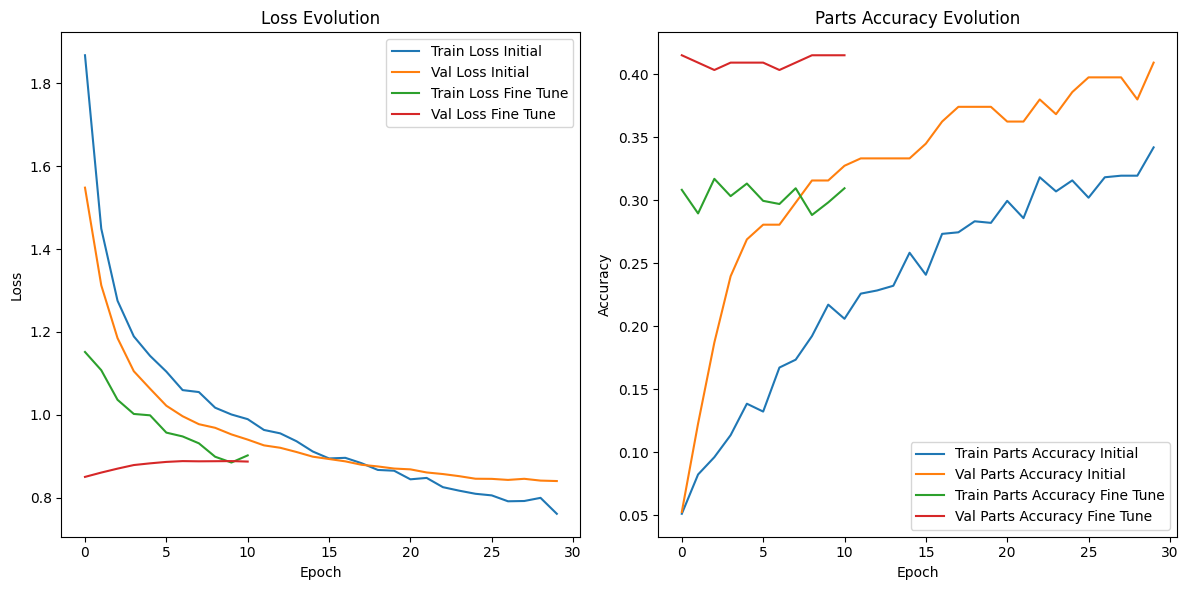

In [11]:
# Función para visualizar el historial de entrenamiento
def plot_training_history(history1, history2):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='Train Loss Initial')
    plt.plot(history1.history['val_loss'], label='Val Loss Initial')
    plt.plot(history2.history['loss'], label='Train Loss Fine Tune')
    plt.plot(history2.history['val_loss'], label='Val Loss Fine Tune')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['partes_accuracy'], label='Train Parts Accuracy Initial')
    plt.plot(history1.history['val_partes_accuracy'], label='Val Parts Accuracy Initial')
    plt.plot(history2.history['partes_accuracy'], label='Train Parts Accuracy Fine Tune')
    plt.plot(history2.history['val_partes_accuracy'], label='Val Parts Accuracy Fine Tune')
    plt.title('Parts Accuracy Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizar resultados
plot_training_history(history_initial, history_fine_tune)

In [14]:
# =============================================
# EVALUACIÓN
# =============================================
def evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias):
    """Evalúa el modelo en el conjunto de prueba y muestra métricas"""
    # Evaluación general
    results = model.evaluate(test_generator, verbose=1)
    print(f"Pérdida total: {results[0]}")
    print(f"Pérdida partes: {results[1]} - Accuracy partes: {results[4]}")
    print(f"Pérdida daños: {results[2]} - Accuracy daños: {results[5]}")
    print(f"Pérdida sugerencias: {results[3]} - Accuracy sugerencias: {results[6]}")
    
    # Predicciones
    print("\nGenerando predicciones...")
    predictions = model.predict(test_generator, verbose=1)
    y_pred_partes = predictions[0] > 0.5
    y_pred_dannos = predictions[1] > 0.5
    y_pred_sugerencias = predictions[2] > 0.5
    
    # Obtener etiquetas verdaderas
    y_true_partes = test_generator.mlb_partes.transform(test_df['partes'])
    y_true_dannos = test_generator.mlb_dannos.transform(test_df['dannos'])
    y_true_sugerencias = test_generator.mlb_sugerencias.transform(test_df['sugerencias'])
    
    # Convertir IDs de clases a nombres
    def get_class_names(classes, label_dict):
        return [str(label_dict.get(int(cls), f"Clase_{cls}")) for cls in classes]
    
    partes_names = get_class_names(mlb_partes.classes_, label_to_cls_piezas)
    dannos_names = get_class_names(mlb_dannos.classes_, label_to_cls_danos)
    sugerencias_names = get_class_names(mlb_sugerencias.classes_, label_to_cls_sugerencias)
    
    # Reportes de clasificación
    print("\nReporte para Partes:")
    print(classification_report(
        y_true_partes,
        y_pred_partes,
        target_names=partes_names,
        zero_division=0
    ))
    
    print("\nReporte para Daños:")
    print(classification_report(
        y_true_dannos,
        y_pred_dannos,
        target_names=dannos_names,
        zero_division=0
    ))
    
    print("\nReporte para Sugerencias:")
    print(classification_report(
        y_true_sugerencias,
        y_pred_sugerencias,
        target_names=sugerencias_names,
        zero_division=0
    ))
    
    return {
        'results': results,
        'predictions': {
            'partes': y_pred_partes,
            'dannos': y_pred_dannos,
            'sugerencias': y_pred_sugerencias
        },
        'true_labels': {
            'partes': y_true_partes,
            'dannos': y_true_dannos,
            'sugerencias': y_true_sugerencias
        }
    }

# Realizar evaluación
evaluation_results = evaluate_model(model, test_generator, mlb_partes, mlb_dannos, mlb_sugerencias)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - dannos_accuracy: 0.5638 - dannos_loss: 0.3415 - loss: 0.8582 - partes_accuracy: 0.3510 - partes_loss: 0.1961 - sugerencias_accuracy: 0.8775 - sugerencias_loss: 0.3190
Pérdida total: 0.8709885478019714
Pérdida partes: 0.2027958631515503 - Accuracy partes: 0.5722543597221375
Pérdida daños: 0.35367903113365173 - Accuracy daños: 0.35260117053985596
Pérdida sugerencias: 0.30909252166748047 - Accuracy sugerencias: 0.8786126971244812

Generando predicciones...
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 629ms/step

Reporte para Partes:
                                  precision    recall  f1-score   support

                            Capó       0.00      0.00      0.00        12
                   Faros derecho       0.00      0.00      0.00        11
                 Faros izquierdo       0.00      0.00      0.00         9
  Guardabarros delantero derecho       0.00      0.00      0.00        16
Guardabarros delantero izquierdo       0.00      0.00      0.00      

In [15]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES
# =============================================
def predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """Realiza predicciones para una nueva imagen"""
    # Cargar y preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Hacer predicción
    predictions = model.predict(img_array)
    
    # Procesar resultados
    partes_probs = predictions[0][0]
    dannos_probs = predictions[1][0]
    sugerencias_probs = predictions[2][0]
    
    # Obtener las clases con mayor probabilidad (top 3 para cada categoría)
    top_partes = sorted(zip(mlb_partes.classes_, partes_probs), key=lambda x: x[1], reverse=True)[:3]
    top_dannos = sorted(zip(mlb_dannos.classes_, dannos_probs), key=lambda x: x[1], reverse=True)[:3]
    top_sugerencias = sorted(zip(mlb_sugerencias.classes_, sugerencias_probs), key=lambda x: x[1], reverse=True)[:3]
    
    # Convertir IDs a nombres
    def get_names(items, label_dict):
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in items]
    
    partes_nombres = get_names(top_partes, label_to_cls_piezas)
    dannos_nombres = get_names(top_dannos, label_to_cls_danos)
    sugerencias_nombres = get_names(top_sugerencias, label_to_cls_sugerencias)
    
    return {
        'partes': partes_nombres,
        'dannos': dannos_nombres,
        'sugerencias': sugerencias_nombres
    }

def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

In [16]:
# Ejemplo de uso
image_path = "../data/predecir/golpe_01.jpg"  # Asegúrate que esta ruta es correcta
prediction = predict_damage(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias)
print_predictions(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step

Predicciones para la imagen:

Partes:
- Rueda: 30.84% de probabilidad
- Parachoques delantero: 19.86% de probabilidad
- Parachoques trasero: 17.81% de probabilidad

Dannos:
- Abolladura: 54.10% de probabilidad
- Rotura: 43.76% de probabilidad
- Rayón: 17.52% de probabilidad

Sugerencias:
- Reparar: 81.39% de probabilidad
- Reemplazar: 33.82% de probabilidad


In [17]:
# Ruta a la imagen de prueba
# image_path = "../data/predecir/golpe_01.jpg"
# image_path = "../data/predecir/golpe_02.jpg"
# image_path = "../data/predecir/golpe_03.jpg"
# image_path = "../data/predecir/Siniestro_04.jpg"
# image_path = "../data/predecir/Siniestro_03.jpg"
# image_path = "../data/predecir/Siniestro_02.jpg"
# image_path = "../data/predecir/Siniestro_01.jpg"
# image_path = "../data/predecir/rayon_01.jpg"
# image_path = "../data/predecir/rayon_02.jpg"
image_path = "../data/predecir/mica_rota_01.jpg"
# image_path = "../data/predecir/mica_rota-rayon_01.jpg"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


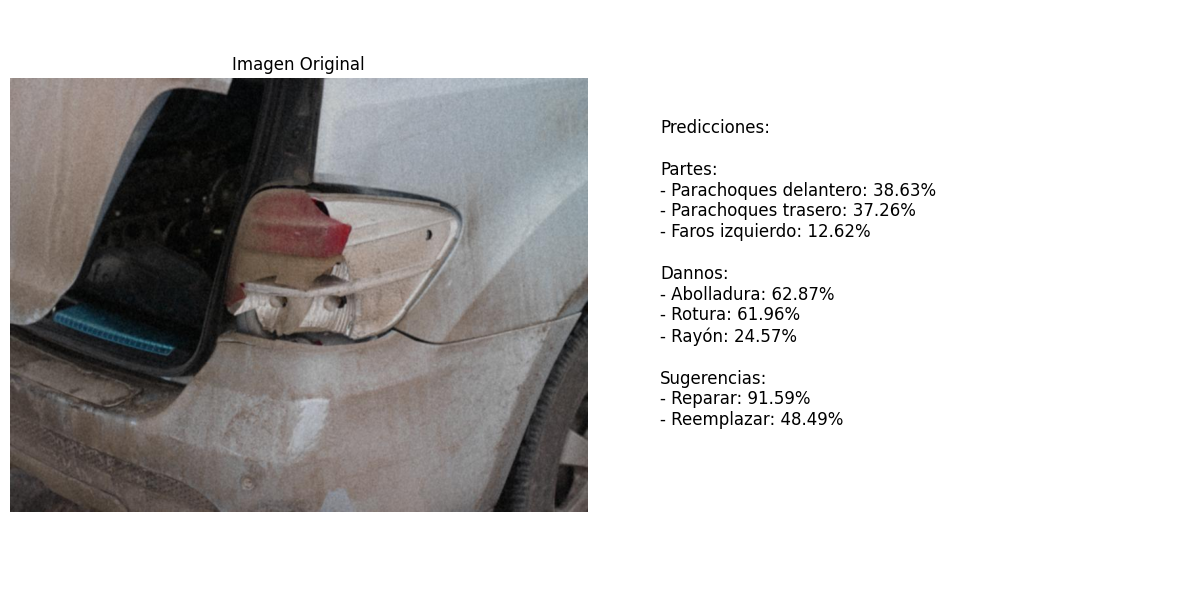


Predicciones para la imagen:

Partes:
- Parachoques delantero: 38.63% de probabilidad
- Parachoques trasero: 37.26% de probabilidad
- Faros izquierdo: 12.62% de probabilidad

Dannos:
- Abolladura: 62.87% de probabilidad
- Rotura: 61.96% de probabilidad
- Rayón: 24.57% de probabilidad

Sugerencias:
- Reparar: 91.59% de probabilidad
- Reemplazar: 48.49% de probabilidad


In [18]:
# =============================================
# PREDICCIÓN EN NUEVAS IMÁGENES CON VISUALIZACIÓN
# =============================================
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show(image_path, model, mlb_partes, mlb_dannos, mlb_sugerencias, img_size=(224, 224)):
    """
    Realiza predicciones para una nueva imagen y la muestra junto con los resultados
    
    Args:
        image_path: Ruta a la imagen a predecir
        model: Modelo cargado para hacer predicciones
        mlb_partes: MultiLabelBinarizer para partes
        mlb_dannos: MultiLabelBinarizer para daños
        mlb_sugerencias: MultiLabelBinarizer para sugerencias
        img_size: Tamaño de la imagen para redimensionamiento
    """
    # Configurar el gráfico
    plt.figure(figsize=(12, 6))
    
    # 1. Mostrar la imagen original
    img = tf.keras.preprocessing.image.load_img(image_path)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen Original")
    plt.axis('off')
    
    # 2. Preprocesar la imagen para el modelo
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.image.resize(img_array, img_size)
    img_array = applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    
    # 3. Hacer predicción
    predictions = model.predict(img_array)
    
    # 4. Procesar resultados
    def get_top_predictions(classes, probs, label_dict, top_n=3):
        """Obtiene las top N predicciones con sus nombres y probabilidades"""
        top_items = sorted(zip(classes, probs[0]), key=lambda x: x[1], reverse=True)[:top_n]
        return [(label_dict.get(int(cls), f"Clase_{int(cls)}"), float(prob)) for cls, prob in top_items]
    
    resultados = {
        'partes': get_top_predictions(mlb_partes.classes_, predictions[0], label_to_cls_piezas),
        'dannos': get_top_predictions(mlb_dannos.classes_, predictions[1], label_to_cls_danos),
        'sugerencias': get_top_predictions(mlb_sugerencias.classes_, predictions[2], label_to_cls_sugerencias)
    }
    
    # 5. Mostrar resultados
    plt.subplot(1, 2, 2)
    text_content = "Predicciones:\n\n"
    
    for category, items in resultados.items():
        text_content += f"{category.capitalize()}:\n"
        if not items:
            text_content += "- No se identificaron predicciones significativas\n"
        else:
            for name, prob in items:
                text_content += f"- {name}: {prob:.2%}\n"
        text_content += "\n"
    
    plt.text(0.1, 0.5, text_content, fontsize=12, va='center')
    plt.axis('off')
    plt.tight_layout()
    
    # Mostrar todo
    plt.show()
    
    return resultados

# Ejemplo de uso:
# image_path = "../data/predecir/Siniestro_01.jpg"  # Cambia esto por tu ruta de imagen
resultados = predict_and_show(
    image_path=image_path,
    model=model,
    mlb_partes=mlb_partes,
    mlb_dannos=mlb_dannos,
    mlb_sugerencias=mlb_sugerencias
)

# También puedes usar la función original si prefieres solo texto
def print_predictions(prediction):
    print("\nPredicciones para la imagen:")
    for category, items in prediction.items():
        print(f"\n{category.capitalize()}:")
        if not items:
            print("- No se identificaron predicciones significativas")
        else:
            for name, prob in items:
                print(f"- {name}: {prob:.2%} de probabilidad")

print_predictions(resultados)

In [19]:
# =============================================
# GUARDAR RESULTADOS
# =============================================
def save_evaluation_results(results, filename='evaluation_results_fine_tuning.json'):
    """Guarda los resultados de evaluación en un archivo JSON"""
    serializable_results = {
        'metrics': {
            'total_loss': float(results['results'][0]),
            'partes_loss': float(results['results'][1]),
            'dannos_loss': float(results['results'][2]),
            'sugerencias_loss': float(results['results'][3]),
            'partes_accuracy': float(results['results'][4]),
            'dannos_accuracy': float(results['results'][5]),
            'sugerencias_accuracy': float(results['results'][6])
        },
        'predictions': {
            'partes': results['predictions']['partes'].tolist(),
            'dannos': results['predictions']['dannos'].tolist(),
            'sugerencias': results['predictions']['sugerencias'].tolist()
        },
        'true_labels': {
            'partes': results['true_labels']['partes'].tolist(),
            'dannos': results['true_labels']['dannos'].tolist(),
            'sugerencias': results['true_labels']['sugerencias'].tolist()
        }
    }
    
    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"Resultados guardados en {filename}")

save_evaluation_results(evaluation_results)

Resultados guardados en evaluation_results_fine_tuning.json
